# Generating CNN architectures automatically using Genetic Algorithms

In [1]:
import random
import json
import time
import pprint

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

print(tf.__version__)

2.8.2


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.style.use("ggplot")

In [4]:
def plot_training_history(history):
    # plotting the training accuracy and loss
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'],loc='upper left')
    plt.figure(figsize = (60,20))
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'],)
    plt.plot(history.history['val_loss'],)
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.figure(figsize = (20,10))
    plt.show()

# ResNets

This project is based in ResNets, using this kind of Convolutional Neural Networks allows us to make very deep neural networks avoiding gradient vanishing and overfitting issues.

In [5]:
# Static class Layer
class Layer():
    @staticmethod
    def skip_layer_encode() -> str :
        """
        Return a randomly initialized skip layer with two convolutions

        Returns:
            str: String representing the number of filters in the two
                 convolutions
        """
        f1 = 2 ** random.randint(5, 9) # number from 32 to 512
        f2 = 2 ** random.randint(5, 9) # number from 32 to 512
        return f"{f1}_{f2}"

    @staticmethod
    def pooling_layer_encode() -> str:
        """
        Returns a pooling layer

        Returns:
            str: Mean or Max pooling layer representation
        """
        q = random.random()
        if q < 0.5:
            return "max"
        else:
            return "mean"
        
    @staticmethod
    def random_layer(skip_layer_prob=0.70) -> str:
        """
        Returns randombly skip or pooling layer

        Args:
            skip_layer_prob (float, optional): Probability of getting skip layer. 
            Defaults to 0.75.

        Returns:
            str: A string representation of a layer
        """
        r = random.random()

        if r < skip_layer_prob:
            return Layer.skip_layer_encode()
        else:
            return Layer.pooling_layer_encode()
        
    @staticmethod
    def skip_layer(X, f1, f2, kernel = (3,3), stride = (1,1)) -> tf.keras.layers:
        """
        Returns a convolutional block of a ResNet

        Args:
            X (keras.Layers): Previous layer of a CNN
            f1 (int): Number of filters in first convolution
            f2 (int): Number of filters in second convolution
            kernel (tuple, optional): Filter shape. Defaults to (3,3).
            stride (tuple, optional): Stride shape. Defaults to (1,1).

        Returns:
            keras.layers: The output of a convolutional block
        """
        inputs = X

        # First convolution
        layer = Conv2D(f1, kernel_size=kernel, strides=stride, padding="same")(X)
        layer = BatchNormalization(axis=3)(layer)
        layer = Activation("relu")(layer)

        # Second convolution
        layer = Conv2D(f2, kernel_size=kernel, strides=stride, padding="same")(layer)
        layer = BatchNormalization(axis=3)(layer)

        # Inter convolution (makes sure that the dimensionality at the skip layers are the same)
        inputs = Conv2D(f2, kernel_size=(1,1), strides=stride, padding="same")(inputs)

        # We add the input and the second convolution layers
        outputs = Add()([inputs, layer])
        outputs = Activation("relu")(outputs)

        return outputs
    
    @staticmethod
    def pooling_layer(X, pooling_type, kernel = (2,2), stride = (2,2)) -> tf.keras.layers:
        """
        Returns whether a MeanPooling2D or MaxPooling2D layer

        Args:
            X (keras.layers): Previous layer of a CNN
            pooling_type (str): The type of pooling layer
            kernel (tuple, optional): Pooling filter shape. Defaults to (2,2).
            stride (tuple, optional): Stride shape. Defaults to (2,2).

        Returns:
            tf.keras.layers: Whether a Max or Mean pooling layer
        """
        pooling_choices = {
            "max": MaxPooling2D,
            "mean": AveragePooling2D
        }

        return pooling_choices[pooling_type](pool_size=kernel, strides=stride, padding="same")(X)

# Genetic Algorithm

## The CNN class (individual)

In [6]:
# This class represents each individual of our population
class CNN:

    def __init__(self, encoding:str, input_shape:tuple, output_shape:int) -> None:

        """
        Class constructor

        Args:
            encoding (str): Encoding representation of the CNN
            input_shape (tuple): Input shape of the CNN (height, width, channels)
            output_shape (int): Number of classes of the CNN
        """

        # Genetic Algorithm stuff
        self.genes = encoding.split("-") # List of genes (cnn layers)
        self.num_genes = len(self.genes) # Number of genes (cnn layers)

        # CNN stuff
        self.encoding = encoding         # Encoded representation of the CNN
        self.input_shape = input_shape   # Input shape (WIDTH, HEIGHT, CHANNELS)
        self.output_shape = output_shape # Output shape (number of classes)
        self.accuracy = 0.0              # Accuracy of the model
        self.inference_time = 0.0        # Time of the model to make an inference
        self.training_time = 0.0         # Time taken to train

    def generate_model(self) -> tf.keras.Model:
        """
        Generates a Keras model from the encoding

        Returns:
            model: tensorflow.keras.Model
        """
        inputs = Input(shape=self.input_shape)
        outputs = inputs

        # Create a list of layers from the encoding of the cnn
        layers = []
        for layer in self.encoding.split("-"):
            if layer == "mean":
                outputs = Layer.pooling_layer(outputs, "mean")
            elif layer == "max":
                outputs=  Layer.pooling_layer(outputs, "max")
            else:
                # Skip layer
                f1, f2 = layer.split("_")
                outputs = Layer.skip_layer(outputs, int(f1), int(f2))

        # Fully connected layers
        outputs = GlobalMaxPooling2D()(outputs)
#         outputs = Dense(32, activation="relu")(outputs)
        outputs = Dense(self.output_shape, activation="softmax")(outputs)

        return Model(inputs = inputs, outputs = outputs)


    def __str__(self) -> str:

        """
        String representation of the object.
        """

        return f"""Model encoding: {self.encoding}, \nModel Accuracy: {self.accuracy},\nModel inference time: {self.inference_time}"""

    def __hash__(self):
        return hash(self.encoding)
    
    def __eq__(self, other):
        return self.encoding == other.encoding
    
    def get_info(self) -> dict:
        
        """
        Returns a dict with the information of the current individual.

        Returns:
            dict: Dictionary containing class important attributes.
        """
        return {
            "depth": self.num_genes,
            "accuracy" : self.accuracy,
            "inference time": self.inference_time,
            "training time": self.training_time,
        }

## The Population class

In [7]:
class Population:

    def __init__(self, n_individuals, min_genes, max_genes) -> None:
        """
        Class constructor

        Args:
            n_individuals (int): Number of individuals
            min_genes (int): Minimum number of genes an individual can have
            max_genes (int): Maximum number of genes an individual can have
        """
        self.n_individuals = n_individuals
        self.min_genes = min_genes
        self.max_genes = max_genes
        self.individuals = None
        self.best_individual = None
        self.mean_accuracy = 0.0

    def initialize(self, input_shape, output_shape) -> None:
        """
        Randomly initialize the population

        Args:
            input_shape (tuple): Shape of the input
            output_shape (int): Number of classes
        """
        population = [] # List of CNN objects
        
        for _ in range(self.n_individuals):
            new_individual = self.generate_individual(input_shape, output_shape)
            population.append(new_individual)

        self.individuals = population

    def generate_individual(self, input_shape, output_shape) -> CNN:
        """Randombly generates and individual

        Args:
            input_shape (tuple): Shape of the input (width, height, n_channels)
            output_shape (int): Number of output classes

        Returns:
            CNN: Randomly initialized instance of the CNN class
        """
        depth = random.randint(self.min_genes, self.max_genes)
        layers = [Layer.random_layer() for _ in range(depth)]
        layers = "-".join(layers)

        return CNN(layers, input_shape, output_shape)

    def compute_mean_accuracy(self) -> None:
        """
        Computes the mean accuracy of the population
        """
        evaluated_individuals_acc = []
        for individual in self.individuals:
            acc = individual.accuracy
            if acc != 0.0:
                evaluated_individuals_acc.append(acc)

        sum_accuracy = sum(evaluated_individuals_acc)
        self.mean_accuracy = sum_accuracy / len(evaluated_individuals_acc)

    def print(self) -> None:
        """
        Print a table summarizing the information of the population
        """
        self.individuals.sort(key=lambda x: x.accuracy, reverse=True)
        individuals_info = []
        for individual in self.individuals:
            individuals_info.append(
                [individual.num_genes, "-".join(individual.encoding.split("-")[:10]), round(individual.accuracy, 4),
                 round(individual.inference_time, 4)]
            )

        print(tabulate(individuals_info,
        headers=["CNN Depth", "Encoding (just first layers)", "Accuracy", "Inferenece time"],
        numalign="center", stralign="left"))

## The GeneticAlgorithm class

In [8]:
class GeneticAlgorithm:

    def __init__(self, population_size, min_genes, max_genes, mutation_rate, crossover_rate, 
                 use_elitism, num_generations, saved_cnns, training_params, elitism_rate=0.1) -> None:
        
        self.population_size = population_size
        self.min_genes = min_genes
        self.max_genes = max_genes
        self.num_generations = num_generations
        
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.use_elitism = use_elitism
        self.elitism_rate = elitism_rate

        self.population = Population(population_size, min_genes, max_genes)
        self.input_shape = training_params["X_train"][0].shape
        self.output_shape = training_params["y_train_cat"][0].shape[0]
        
        self.saved_cnns = saved_cnns
        self.training_params = training_params

        self.accuracy_history = []
        self.best_ind_acc_history = []

    # ====================================================================================
    # ====================================================================================
    def save_architectures(self) -> None:
        """
        Save the evaluated architectures of the population in a JSON file
        """
        # Directly from dictionary
        with open('evaluated_architectures.json', 'w') as outfile:
            json.dump(self.saved_cnns, outfile, indent=4)

    def get_best_individual(self) -> CNN:
        """
        Returns the best individual.
        Looks in the saved cnns dictionary and creates a CNN object with its information.
        
        Returns:
            CNN: The best of all evaluated individuals
        """
        sorted_encodings = sorted(self.saved_cnns, key=lambda x: self.saved_cnns[x]["accuracy"], reverse=True)
        best_encoding = sorted_encodings[0]

        best_individual_info = self.saved_cnns[best_encoding]
        best_individual = CNN(best_encoding, self.input_shape, self.output_shape)
        best_individual.accuracy = best_individual_info["accuracy"]
        best_individual.inference_time = best_individual_info["inference time"]
        best_individual.training_time = best_individual_info["training time"]

        return best_individual
    
    # ====================================================================================
    # ====================================================================================
    def evaluate_population(self) -> None:
        """
        Evaluate every CNN in the population and calculates its metrics
        """

        # Get training params
        X_train = self.training_params["X_train"]
        X_test = self.training_params["X_test"]
        y_train_cat = self.training_params["y_train_cat"]
        y_test_cat = self.training_params["y_test_cat"]
        epochs = self.training_params["epochs"]
        batch_size = self.training_params["batch_size"]

        # If we already have a best individual, we take its accuracy as the best
        if self.population.best_individual is not None:
            best_acc = self.population.best_individual.accuracy
        else:
            best_acc = 0.0

        for i, individual in enumerate(self.population.individuals, start=1):
            print(f" Individual {i} of {self.population_size} ".center(100, "="))
            # Check if our architecture is already in the saved cnns dict
            if individual.encoding in self.saved_cnns and self.saved_cnns[individual.encoding]["epochs"] == epochs:
                print(f"Architecture {individual.encoding} already evaluated")
            else:
                # Creating individual model
                model = individual.generate_model()
                model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
                callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                              patience=3, 
                                                              restore_best_weights=True)]
                print(f"Architecture: {individual.encoding}, Depth: {individual.num_genes}")
                print("Training ...")
                
                # Training the model
                time1 = time.perf_counter()
                history = model.fit(X_train, y_train_cat, epochs=epochs, batch_size=batch_size, 
                                               validation_split=0.15, verbose=0, callbacks=callbacks)
                time2 = time.perf_counter()
                individual.training_time = (time2 - time1)/60   # Time in minutes

                # Evaluating the model
                print("Evaluating the model with unseen data ...")
                val_loss, val_acc = model.evaluate(X_test, y_test_cat, batch_size=batch_size)

                # Measuring inference time
                time1 = time.perf_counter()
                predictions = model.predict(X_test)
                time2 = time.perf_counter()
                individual.inference_time = ((time2 - time1)/X_test.shape[0]) * 1000 # time in milliseconds
                print(f"Inference time: {individual.inference_time} milliseconds.")
                
                individual.accuracy = val_acc

                if val_acc > best_acc:
                    self.population.best_individual = individual
                    best_acc = val_acc

                self.saved_cnns[individual.encoding] = individual.get_info()
                self.saved_cnns[individual.encoding]["epochs"] = epochs
                
        # Storing population parameters
        self.population.compute_mean_accuracy()
        self.accuracy_history.append(self.population.mean_accuracy)
        self.best_ind_acc_history.append(self.population.best_individual.accuracy)

        print("\nEvery individual in the population has been evaluated! ...")

    # ====================================================================================
    # ====================================================================================
    def choose_winner(self, ind1, ind2) -> CNN:
        """
        Choose a winner from the tournamen selection considering the accuracy
        and the inference time of two networks.

        An individual would be better than other if it is 30% (or greater)
        faster and it is maximum 3% less acurate.

        Args:
            ind1 (CNN): An individual
            ind2 (CNN): An individual

        Returns:
            CNN: The winner individual
        """
        # None of the selected individuals has been evaluated
        if ind1.accuracy == 0.0 and ind2.accuracy == 0.0:
            return random.choice([ind1, ind2])
        
        elif ind1.accuracy == 0.0 and ind2.accuracy != 0.0:
            return ind2
        
        elif ind1.accuracy != 0.0 and ind2.accuracy == 0.0:
            return ind1
        
        # Both of the individuals has been evaluated        
        if abs(ind1.accuracy - ind2.accuracy) < 0.03:
            fastest = ind1 if ind1.inference_time < ind2.inference_time else ind2
            slowest = ind1 if ind1.inference_time > ind2.inference_time else ind2

            if fastest.inference_time / slowest.inference_time <= 0.7:
                return fastest
            return slowest
        
        more_accurate = ind1 if ind1.accuracy > ind2.accuracy else ind2
        
        return more_accurate

    # ====================================================================================
    # ====================================================================================
    def tournament_selection(self, num_individuals) -> list:
        """
        A list containing the winners of the tournament selection

        Args:
            num_individuals (int): How many individuals to generate in the offspring

        Returns:
            list: The offspring of the population
        """

#         print("Tournament Selection".center(30, "="))

        offspring = []

        # Fill the offspring by tournament
        while len(offspring) < num_individuals:
            # Select two individuals
            ind1 = random.choice(self.population.individuals)
            ind2 = random.choice(self.population.individuals)

            winner = self.choose_winner(ind1, ind2)

#             print(f"Selected individuals: {ind1.encoding} acc: {round(ind1.accuracy, 4)} & {ind2.encoding} acc: {round(ind2.accuracy, 4)} Winner: {winner.encoding}")

            offspring.append(winner)

        return offspring

    # ====================================================================================
    # ====================================================================================
    def cross(self, parent1, parent2, cross_point) -> tuple:
        """
        Returns the resulting individuals of crossing their parents

        Args:
            parent1 (CNN): One of the parents
            parent2 (CNN): One of the parents
            cross_point (int): Index of the genes list in wich the crossing will be done

        Returns:
            tuple: The decendents resulting from the crossing
        """
        genes1 = parent1.genes[:cross_point+1] + parent2.genes[cross_point+1:]
        genes2 = parent2.genes[:cross_point+1] + parent1.genes[cross_point+1:]

        genes1 = "-".join(genes1)
        genes2 = "-".join(genes2)

        son1 = CNN(genes1, self.input_shape, self.output_shape)
        son2 = CNN(genes2, self.input_shape, self.output_shape)

        return son1, son2

    # ====================================================================================
    # ====================================================================================
    def crossover(self, temp_offspring) -> None:
        """
        Performs the crossover in the population and replaces the needed individuals
        """
        selected_indices = [] # Individuals selected for crossover
        num_selected = 0

        for index in range(len(temp_offspring)):
            r = random.random()
            if r < self.crossover_rate:
                selected_indices.append(index)
        
        if len(selected_indices) % 2 != 0:
            selected_indices.pop()

        for i in range(0, len(selected_indices), 2):
            parent1 = temp_offspring[selected_indices[i]]
            parent2 = temp_offspring[selected_indices[i+1]]

            # We choose a random crossover point from shortest parent
            shortest_parent = parent1 if parent1.num_genes < parent2.num_genes else parent2
            cross_point = random.randint(1, shortest_parent.num_genes-1)

            # We create two individuals based on their parents
            son1, son2 = self.cross(parent1, parent2, cross_point)
            
            # New individuals replace their parents
            temp_offspring[i]   = son1
            temp_offspring[i+1] = son2
        
        return temp_offspring

    # ====================================================================================
    # ====================================================================================
    def mutation(self) -> None:
        """
        Performs the mutation in the population.
        There are four types of mutations:
            - Increment depth of the net
            - Reduce depth of the net
            - Change layer type
            - Recreate a layer
        """

        possible_mutations = ("increment_depth", "reduce_depth", "change_layer_type", "recreate_layer")

        # We loop over the genes of every individual in population
        for individual in self.population.individuals:

            # We make a copy so we dont modify our list while iterating
            mutated_genes = individual.genes.copy()

            for n_gene, gene in enumerate(individual.genes):
                r = random.random()
                if r < self.mutation_rate:
                    # Mutate
#                     print("Mutation".center(20, "="))
#                     print(f"Individual to mutate: {individual.encoding}")

                    mutation_type = random.choice(possible_mutations)
                    
                    if mutation_type == "increment_depth":
                        # Put a layer after this layer
                        new_layer = Layer.random_layer()
                        mutated_genes.insert(n_gene + 1, new_layer)
                        break    

                    elif mutation_type == "reduce_depth":
                        # Delete the current layer
                        removed = mutated_genes.pop(n_gene)
#                         print(f"{removed} Removed from layers")
                        break

                    elif mutation_type == "change_layer_type":
                        # Put Skip layer if Mean layer or vice versa
                        if gene == "mean" or gene == "max":
                            # Generate a skip layer
                            mutated_genes[n_gene] = Layer.skip_layer_encode()
                        else:
                            mutated_genes[n_gene] = Layer.pooling_layer_encode()
                        break
                            
                    elif mutation_type == "recreate_layer":
                        if gene == "mean" or gene == "max":
                            # Generate a skip layer
                            mutated_genes[n_gene] = Layer.pooling_layer_encode()
                        else:
                            mutated_genes[n_gene] = Layer.skip_layer_encode()
                        break

#             print(f"Individual before: {individual.genes}")
            individual.genes = mutated_genes
#             print(f"Individual after: {individual.genes}")

    # ====================================================================================
    # ====================================================================================
    def elitism(self, elite_size) -> None:
        """
        Performs elitism in the population
        """
        # Sort individuals by accuracy
        indiv_sorted = sorted(self.population.individuals, key=lambda x: x.accuracy, reverse=True)
        population_elite = indiv_sorted[:elite_size]   # Select the best individuals
        
#         print(f"The population elite: {population_elite}")
#         print(f"Population sorted: {indiv_sorted}")
        
        return population_elite            

    # ====================================================================================
    # ====================================================================================
    def delete_individual_copies(self) -> None:
        """
        Delete the extra copies of individuals in the population
        """
        individuals_set = set(self.population.individuals)
#         print(f"Population normal: {self.population.individuals}")
#         print(f"Population set: {individuals_set}")
#         print(f"The two sets are equal: {self.population.individuals == list(individuals_set)}")
        number_missing = len(self.population.individuals) - len(individuals_set)
        new_individuals = [self.population.generate_individual(self.input_shape, self.output_shape) \
                           for _ in range(number_missing)]

        new_population = [*individuals_set, *new_individuals]
#         print(f"Size of the new population: {len(new_population)}")
        
        self.population.individuals = new_population
        
    # ====================================================================================
    # ====================================================================================
    def main_loop(self) -> None:
        """
        The main loop of the Genetic Algorithm
        """
        print("="*100)
        print("Initializing Genetic Algorithm loop with the next parameters")
        print(f"Number of generations: {self.num_generations}")
        print(f"Population size: {self.population_size}")
        print(f"Min individuals size: {self.min_genes}")
        print(f"Max individuals size: {self.max_genes}")
        print(f"Crossover rate: {self.crossover_rate}")
        print(f"Mutation rate: {self.mutation_rate}")
        print(f"Using elitism: {self.use_elitism}")
        if self.use_elitism:
            print(f"Elitism size: {self.elitism_rate}% of population")
        print("="*100)
        
        # Initialize population
        self.population.initialize(self.input_shape, self.output_shape)

        # Print individuals
        print("Starting evolution loop with the next population:")
        self.population.print()

        # Evaluate population
        self.evaluate_population()

        print("Evaluation summary".center(30, " "))
        self.population.print()
        self.save_architectures()
        
        print(f"Population mean accuracy: {self.population.mean_accuracy}")


        for generation in range(self.num_generations):            
            print("".center(100, "="))
            print(f"Generation {generation + 1}")
            
            # ========== Elitism ===============
            elite_size = 0  # To avoid non declared variable in tournament selection
            if self.use_elitism:
                elite_size = int(self.population_size * self.elitism_rate)
                elite_offspring = self.elitism(elite_size)

            # ========== Selection =============
            temp_offspring = self.tournament_selection(self.population_size - elite_size)

            # ========== Crossover =============
            self.population.individuals = self.crossover(temp_offspring)

            # ========== Mutation ==============
            self.mutation()

            # === Insert elite in population ==
            if self.use_elitism:
                self.population.individuals.extend(elite_offspring)
            
            # = Delete duplicate individuals ==
            self.delete_individual_copies()    # Delete duplicated individuals and generate new if needed
            
            # ========== Evaluation ============
            self.evaluate_population()
            
            # ======= Print population =========
            self.population.print()
            
            # ======= Mean accuracy of population =========
            print(f"Population mean accuracy: {self.population.mean_accuracy}")
            
            # == Save architectures in file ====
            self.save_architectures()
        
        

# Running the evolution loop

## Preparing our parameters

### Lloading the architectures that have already been evaluated

In [9]:
# Dictionary of saved architectures with it's parameters
with open("evaluated_architectures.json") as file:
    saved_cnns = json.load(file)

### Lloading the data set with which the individuals will be evaluated: CIFAR 10

In [10]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

170508288/170498071 [==============================] - 2s 0us/step


### Setting the training parameters

In [11]:
training_params = {
    "epochs" : 4,
    "batch_size" : 16,
    "X_train" : X_train,
    "X_test" : X_test,
    "y_train_cat" : y_train_cat,
    "y_test_cat" : y_test_cat
}

### Setting the Genetic Algorithm parameters

In [12]:
population_size=10  # How many CNN will be in the population
min_genes=5         # Minimum depth of the CNN's
max_genes=15        # Maximum depth of the CNN's
num_generations=10
mutation_rate=0.10  # Mutation rate 
crossover_rate=0.4  # Crossover rate (value by convention)
use_elitism = True  # Indicates if we will use elitism strategy
elitism_rate = 0.2

---
## Evolution of our genetic algorithm

In [13]:
ga = GeneticAlgorithm(
    population_size=population_size,  # How many CNN will be in the population
    min_genes=min_genes,              # Minimum depth of the CNN's
    max_genes=max_genes,              # Maximum depth of the CNN's
    num_generations=num_generations,
    mutation_rate=mutation_rate,
    crossover_rate=crossover_rate,
    use_elitism = use_elitism,        # Indicates if we will use elitism strategy
    elitism_rate = elitism_rate,      # Indicates elite size in terms of population size
    saved_cnns=saved_cnns,            # Stores already trained individuals
    training_params=training_params   # Parameters needed for training
)

In [ ]:
t1 = time.perf_counter()
ga.main_loop()
t2 = time.perf_counter()
print(f"Time taken: {(t2-t1)/3600} hours.")

Initializing Genetic Algorithm loop with the next parameters
Number of generations: 10
Population size: 10
Min individuals size: 5
Max individuals size: 15
Crossover rate: 0.4
Mutation rate: 0.1
Using elitism: True
Elitism size: 0.2% of population
Starting evolution loop with the next population:
 CNN Depth   Encoding (just first layers)                                              Accuracy    Inferenece time
-----------  -----------------------------------------------------------------------  ----------  -----------------
     7       max-32_32-256_64-64_32-512_128-128_256-32_512                                0               0
     9       64_256-64_256-mean-512_32-max-mean-mean-256_128-256_512                      0               0
     8       max-512_32-64_64-32_32-max-max-512_64-mean                                   0               0
     9       128_256-64_64-256_32-32_64-max-256_64-256_32-mean-64_32                      0               0
    12       128_512-512_64-128_512-max

2022-07-06 08:18:01.522631: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-06 08:18:02.238228: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30988 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1e:00.0, compute capability: 7.0


Architecture: max-32_32-256_64-64_32-512_128-128_256-32_512, Depth: 7
Training ...


2022-07-06 08:18:05.273789: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


Evaluating the model with unseen data ...
625/625 [==============================] - 3s 5ms/step - loss: 1.0377 - accuracy: 0.6283
Inference time: 0.18473394783213734 milliseconds.
======================================== Individual 2 of 10 ========================================
Architecture: 64_256-64_256-mean-512_32-max-mean-mean-256_128-256_512, Depth: 9
Training ...
Evaluating the model with unseen data ...
625/625 [==============================] - 3s 5ms/step - loss: 0.7792 - accuracy: 0.7307
Inference time: 0.29388997722417115 milliseconds.
======================================== Individual 3 of 10 ========================================
Architecture: max-512_32-64_64-32_32-max-max-512_64-mean, Depth: 8
Training ...
Evaluating the model with unseen data ...
625/625 [==============================] - 2s 3ms/step - loss: 1.1046 - accuracy: 0.6168
Inference time: 0.10925691267475486 milliseconds.
======================================== Individual 4 of 10 ======================

Architecture: 64_512-mean-128_512-max-256_32-128_32-64_256-512_512-32_32, Depth: 9
Training ...
Evaluating the model with unseen data ...
625/625 [==============================] - 4s 6ms/step - loss: 0.9196 - accuracy: 0.6857
Inference time: 0.2991320604458451 milliseconds.

Every individual in the population has been evaluated! ...
 CNN Depth   Encoding (just first layers)                                              Accuracy    Inferenece time
-----------  -----------------------------------------------------------------------  ----------  -----------------
     9       512_32-64_128-32_256-mean-mean-64_128-mean-mean-64_32                       0.8            0.18
    12       512_32-64_128-32_256-mean-mean-64_128-mean-mean-32_64-max                   0.77           0.19
    12       128_256-64_64-256_32-32_64-max-256_64-256_32-mean-32_64-max                 0.76           0.23
    12       512_128-64_64-32_256-128_64-32_256-mean-max-128_32-32_256-32_32             0.74            0

Architecture: 32_128-512_512-128_64-128_256-32_32-256_256-128_32-64_64-mean-max-128_512-512_32-mean, Depth: 13
Training ...
Evaluating the model with unseen data ...
625/625 [==============================] - 7s 11ms/step - loss: 0.8331 - accuracy: 0.7138
Inference time: 0.6090261013247072 milliseconds.
======================================== Individual 9 of 10 ========================================
Architecture: 64_256-32_256-256_128-128_64-512_256-mean-512_512-256_64-max-512_128-128_64-64_256-256_64-32_256-max, Depth: 15
Training ...
Evaluating the model with unseen data ...
625/625 [==============================] - 7s 10ms/step - loss: 0.9407 - accuracy: 0.6745
Inference time: 0.5701115537434817 milliseconds.
======================================= Individual 10 of 10 ========================================
Architecture: mean-max-512_512-32_128-mean-256_128-64_32-128_256-max, Depth: 9
Training ...
Evaluating the model with unseen data ...
625/625 [==============================

Architecture: 64_32-128_64-128_32-512_32-128_64-max-128_32-32_256-mean-max-max-128_512-512_32-mean, Depth: 14
Training ...
Evaluating the model with unseen data ...
625/625 [==============================] - 5s 7ms/step - loss: 0.6817 - accuracy: 0.7656
Inference time: 0.22427795864641667 milliseconds.
======================================== Individual 7 of 10 ========================================
Architecture 512_32-64_128-32_256-mean-mean-64_128-mean-mean-64_32 already evaluated
======================================== Individual 8 of 10 ========================================
Architecture: 32_32-32_32-256_128-128_32-256_512-256_32-mean-512_128-64_256-128_64, Depth: 10
Training ...
Evaluating the model with unseen data ...
625/625 [==============================] - 6s 8ms/step - loss: 1.2153 - accuracy: 0.5861
Inference time: 0.5665984347462655 milliseconds.
======================================== Individual 9 of 10 ========================================
Architecture: 256_512

Evaluating the model with unseen data ...
625/625 [==============================] - 3s 4ms/step - loss: 0.6627 - accuracy: 0.7721
Inference time: 0.16211020909249782 milliseconds.
======================================== Individual 4 of 10 ========================================
Architecture 64_128-32_256-mean-mean-max-64_128-64_128-32_512 already evaluated
======================================== Individual 5 of 10 ========================================
Architecture 512_128-512_256-mean-256_32-256_256-mean-128_32-64_64-mean-max-128_512-512_32-mean already evaluated
======================================== Individual 6 of 10 ========================================
Architecture 64_128-32_256-mean-mean-max-128_64-64_32 already evaluated
======================================== Individual 7 of 10 ========================================
Architecture: 128_256-32_256-mean-mean-max-128_64-64_32-32_512, Depth: 8
Training ...
Evaluating the model with unseen data ...
625/625 [============

Evaluating the model with unseen data ...
625/625 [==============================] - 4s 6ms/step - loss: 0.8118 - accuracy: 0.7291
Inference time: 0.5515266736038029 milliseconds.
======================================== Individual 5 of 10 ========================================
Architecture 128_256-32_256-mean-mean-max-128_64-64_32-32_512 already evaluated
======================================== Individual 6 of 10 ========================================
Architecture 512_32-64_128-32_256-mean-mean-64_128-mean-mean-64_32 already evaluated
======================================== Individual 7 of 10 ========================================
Architecture 256_32-512_32-32_128-mean-128_256-mean-max-128_512-64_64-mean-32_128 already evaluated
======================================== Individual 8 of 10 ========================================
Architecture: 64_256-128_128-256_64-256_256-128_256-512_256-128_64-mean-max-max-256_32-256_512-256_32, Depth: 13
Training ...
Evaluating the model with

## Visualizing population mean accuracy during generations

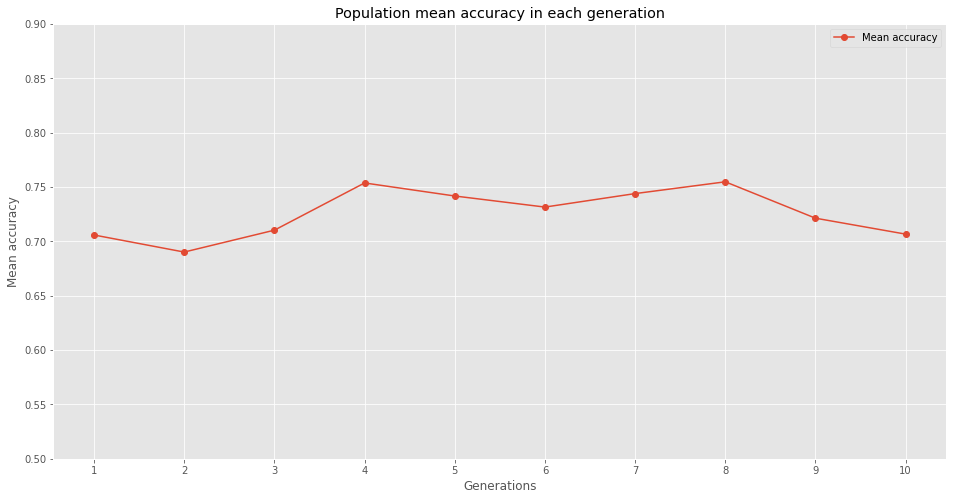

In [ ]:
X = np.arange(1, num_generations+1, 1)
y = ga.accuracy_history
plt.plot(X, y[1:], label="Mean accuracy", marker="o")
plt.legend()

plt.title("Population mean accuracy in each generation")
plt.xlabel("Generations")
plt.ylabel("Mean accuracy")
plt.yticks(np.arange(0.5, 0.95, 0.05))
plt.xticks(np.arange(1, num_generations+1, 1))
plt.show()

## Visualizing Best individual accuracy during generations

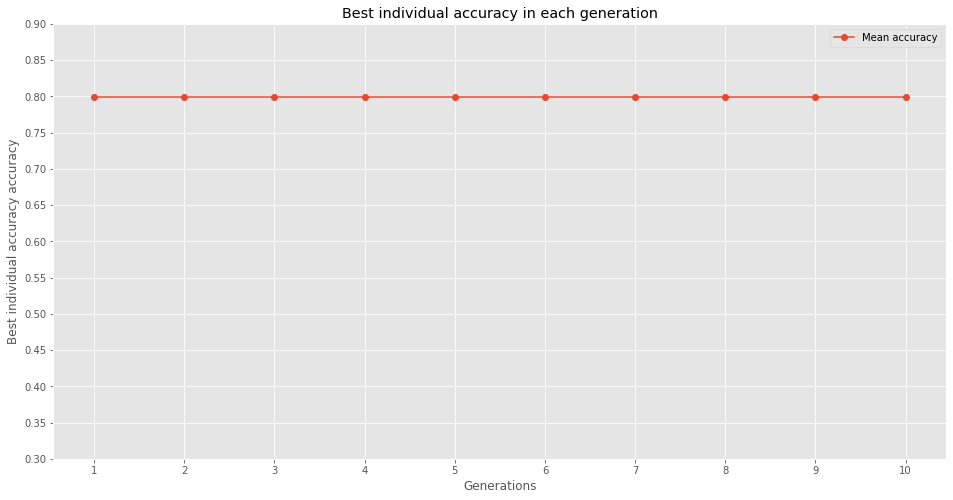

In [ ]:
X = np.arange(1, num_generations+1, 1)
y = ga.best_ind_acc_history
plt.plot(X, y[1:], label="Mean accuracy", marker="o")
plt.legend()

plt.title("Best individual accuracy in each generation")
plt.xlabel("Generations")
plt.ylabel("Best individual accuracy accuracy")
plt.yticks(np.arange(0.3, 0.95, 0.05))
plt.xticks(np.arange(1, num_generations+1, 1))
plt.show()

# Getting the Best Individual of our last population

In [14]:
best_ind = ga.get_best_individual()
print(f"""Best individual information:
Encoding: {best_ind.encoding}
Length: {best_ind.num_genes}
Accuracy: {best_ind.accuracy}
Inference time: {best_ind.inference_time}
Training time: {best_ind.training_time}
""")

Best individual information:
Encoding: 512_32-64_128-32_256-mean-mean-64_128-mean-mean-64_32
Length: 9
Accuracy: 0.7993999719619751
Inference time: 0.1769156211987138
Training time: 2.3969981568555037



# Training our best individual from scratch with more epochs

In [15]:
n_epochs = 30
batch_size = training_params["batch_size"]

In [16]:
# We generate the model again to get fresh weights and train it from scratch
genetic_model = best_ind.generate_model()

# Compiling model
genetic_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Model Checkpoint callback save the best model, not last.
checkpoint_genetic_name = "genetic_best.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_genetic_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=5)
callbacks = [checkpoint, early_stopping]

In [17]:
genetic_model_history = genetic_model.fit(
    X_train, y_train_cat,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=0.15,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/30
2657/2657 [==============================] - ETA: 0s - loss: 1.4204 - accuracy: 0.4880
Epoch 1: val_loss improved from inf to 0.98798, saving model to genetic_best.h5
2657/2657 [==============================] - 75s 23ms/step - loss: 1.4204 - accuracy: 0.4880 - val_loss: 0.9880 - val_accuracy: 0.6491
Epoch 2/30
2656/2657 [============================>.] - ETA: 0s - loss: 0.8364 - accuracy: 0.7055
Epoch 2: val_loss improved from 0.98798 to 0.78760, saving model to genetic_best.h5
2657/2657 [==============================] - 59s 22ms/step - loss: 0.8364 - accuracy: 0.7055 - val_loss: 0.7876 - val_accuracy: 0.7255
Epoch 3/30
2657/2657 [==============================] - ETA: 0s - loss: 0.6390 - accuracy: 0.7784
Epoch 3: val_loss improved from 0.78760 to 0.62099, saving model to genetic_best.h5
2657/2657 [==============================] - 61s 23ms/step - loss: 0.6390 - accuracy: 0.7784 - val_loss: 0.6210 - val_accuracy: 0.7821
Epoch 4/30
2657/2657 [==============================]

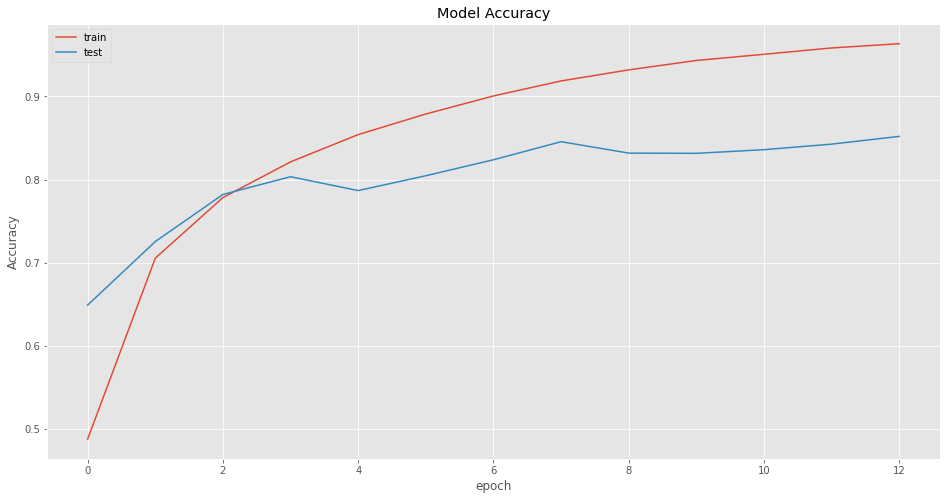

<Figure size 4320x1440 with 0 Axes>

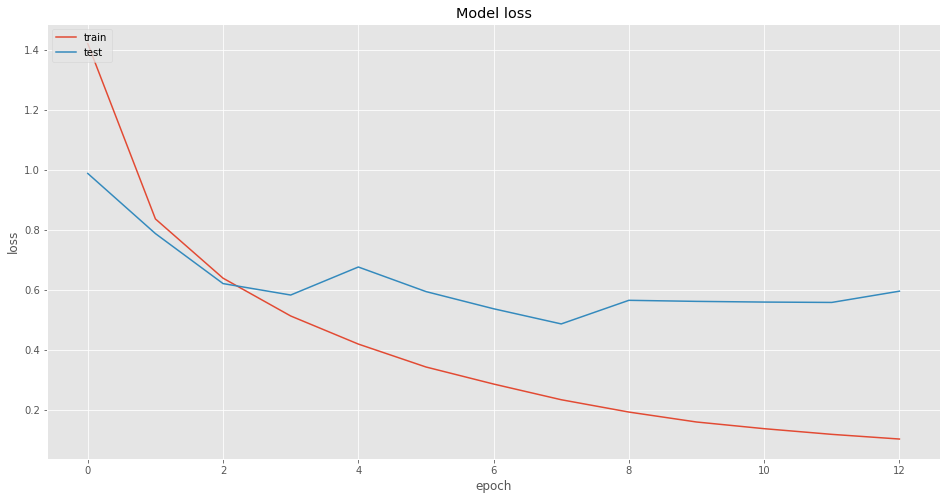

<Figure size 1440x720 with 0 Axes>

In [18]:
plot_training_history(genetic_model_history)

## Validating the model

In [19]:
best_genetic = tf.keras.models.load_model("genetic_best.h5")
genetic_validation = best_genetic.evaluate(X_test, y_test_cat, batch_size=batch_size)
print(" GENETIC Validation results ".center(50,"="))
print(f"Test loss: {genetic_validation[0]}, Test accuracy: {genetic_validation[1]}")

time1 = time.perf_counter()
predictions = best_genetic.predict(X_test)
time2 = time.perf_counter()
best_genetic_model_inference_time = ((time2 - time1)/X_test.shape[0]) * 1000

625/625 [==============================] - 5s 8ms/step - loss: 0.5065 - accuracy: 0.8385
=========== GENETIC Validation results ===========
Test loss: 0.5064718127250671, Test accuracy: 0.8385000228881836


# Comparison with famous Architectures

# VGG19

In [30]:
vgg19_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(32,32,3)
)

# Freezing layers
# for layer in vgg19_model.layers:
#     layer.trainable = False

# Getting the last layer
last_layer_name = vgg19_model.layers[-1].name
last_layer = vgg19_model.get_layer(last_layer_name)
last_output = last_layer.output

# Adding fully connected layers to our pretrained model
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(10, activation="softmax")(x)
vgg19_model = tf.keras.Model(vgg19_model.input, x)

# Compiling the model
vgg19_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Model Checkpoint callback save the best model, not last.
checkpoint_vgg19_name = "vgg19_best.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_vgg19_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=5)
callbacks = [checkpoint, early_stopping]

## Training

In [31]:
vgg19_model_history = vgg19_model.fit(
    X_train, y_train_cat,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=0.15,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/30
2657/2657 [==============================] - ETA: 0s - loss: 2.0366 - accuracy: 0.1804
Epoch 1: val_loss improved from inf to 2.40090, saving model to vgg19_best.h5
2657/2657 [==============================] - 84s 31ms/step - loss: 2.0366 - accuracy: 0.1804 - val_loss: 2.4009 - val_accuracy: 0.1767
Epoch 2/30
2657/2657 [==============================] - ETA: 0s - loss: 1.6654 - accuracy: 0.3376
Epoch 2: val_loss improved from 2.40090 to 1.42055, saving model to vgg19_best.h5
2657/2657 [==============================] - 83s 31ms/step - loss: 1.6654 - accuracy: 0.3376 - val_loss: 1.4205 - val_accuracy: 0.4399
Epoch 3/30
2657/2657 [==============================] - ETA: 0s - loss: 1.3773 - accuracy: 0.4771
Epoch 3: val_loss improved from 1.42055 to 1.22690, saving model to vgg19_best.h5
2657/2657 [==============================] - 82s 31ms/step - loss: 1.3773 - accuracy: 0.4771 - val_loss: 1.2269 - val_accuracy: 0.5397
Epoch 4/30
2657/2657 [==============================] - ETA

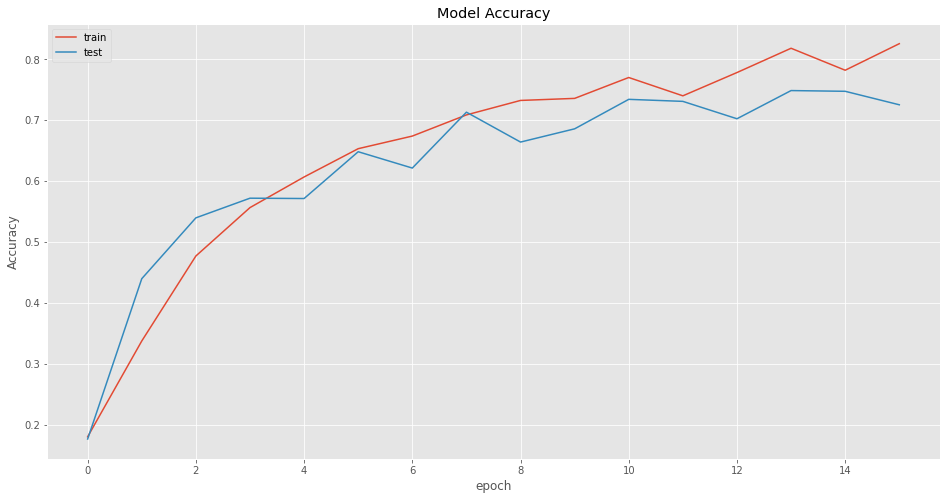

<Figure size 4320x1440 with 0 Axes>

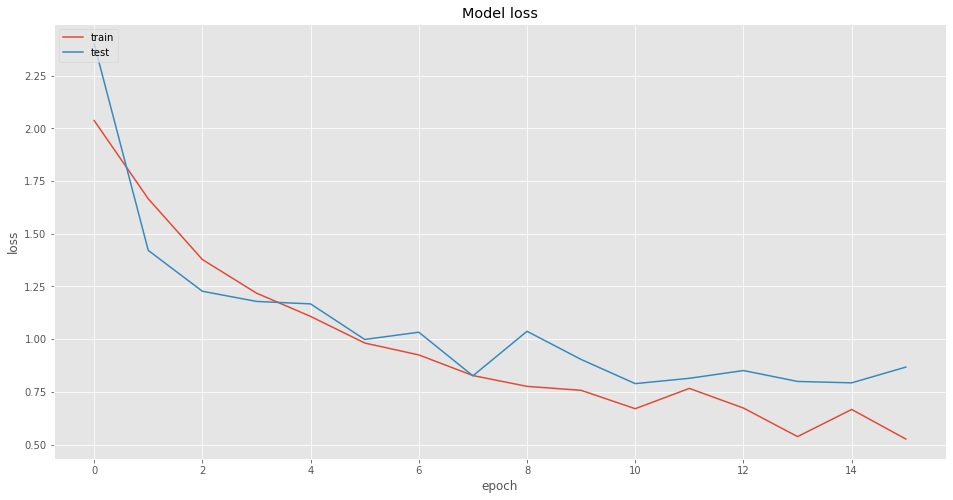

<Figure size 1440x720 with 0 Axes>

In [32]:
plot_training_history(vgg19_model_history)

## Validating the model

In [33]:
best_vgg19 = tf.keras.models.load_model("vgg19_best.h5")
vgg19_validation = best_vgg19.evaluate(X_test, y_test_cat, batch_size=batch_size)
print(" VGG19 Validation results ".center(50,"="))
print(f"Test loss: {vgg19_validation[0]}, Test accuracy: {vgg19_validation[1]}")

time1 = time.perf_counter()
predictions = best_vgg19.predict(X_test)
time2 = time.perf_counter()
best_vgg19_model_inference_time = ((time2 - time1)/X_test.shape[0]) * 1000

625/625 [==============================] - 5s 8ms/step - loss: 0.8317 - accuracy: 0.7291
============ VGG19 Validation results ============
Test loss: 0.831677258014679, Test accuracy: 0.7290999889373779


# ResNet50

In [24]:
ResNet50_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(32,32,3)
)

# Freezing layers
# for layer in ResNet50_model.layers:
#     layer.trainable = False
    
# Getting the last layer
last_layer_name = ResNet50_model.layers[-1].name
last_layer = ResNet50_model.get_layer(last_layer_name)
last_output = last_layer.output

# Adding fully connected layers to our pretrained model
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(10, activation="softmax")(x)
ResNet50_model = tf.keras.Model(ResNet50_model.input, x)

# Compiling the model
ResNet50_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Model Checkpoint callback save the best model, not last.
checkpoint_ResNet50_name = "ResNet50_model.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_ResNet50_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=5)
callbacks = [checkpoint, early_stopping]

94781440/94765736 [==============================] - 2s 0us/step


In [25]:
ResNet50_model_history = ResNet50_model.fit(
    X_train, y_train_cat,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=0.15,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/30
2657/2657 [==============================] - ETA: 0s - loss: 2.2653 - accuracy: 0.2836
Epoch 1: val_loss improved from inf to 9.72233, saving model to ResNet50_model.h5
2657/2657 [==============================] - 114s 40ms/step - loss: 2.2653 - accuracy: 0.2836 - val_loss: 9.7223 - val_accuracy: 0.2125
Epoch 2/30
2657/2657 [==============================] - ETA: 0s - loss: 2.1689 - accuracy: 0.2715
Epoch 2: val_loss improved from 9.72233 to 1.93933, saving model to ResNet50_model.h5
2657/2657 [==============================] - 106s 40ms/step - loss: 2.1689 - accuracy: 0.2715 - val_loss: 1.9393 - val_accuracy: 0.3203
Epoch 3/30
2656/2657 [============================>.] - ETA: 0s - loss: 1.6346 - accuracy: 0.4072
Epoch 3: val_loss improved from 1.93933 to 1.38215, saving model to ResNet50_model.h5
2657/2657 [==============================] - 110s 41ms/step - loss: 1.6347 - accuracy: 0.4072 - val_loss: 1.3822 - val_accuracy: 0.4889
Epoch 4/30
2656/2657 [======================

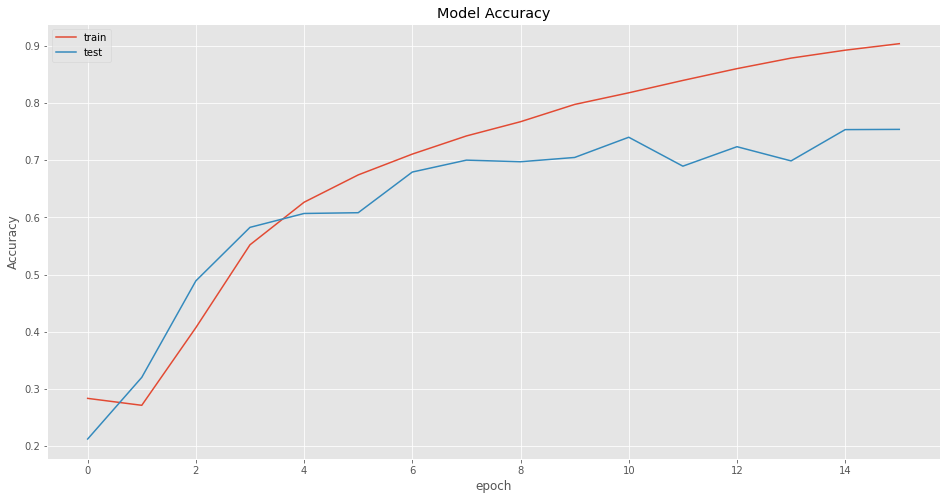

<Figure size 4320x1440 with 0 Axes>

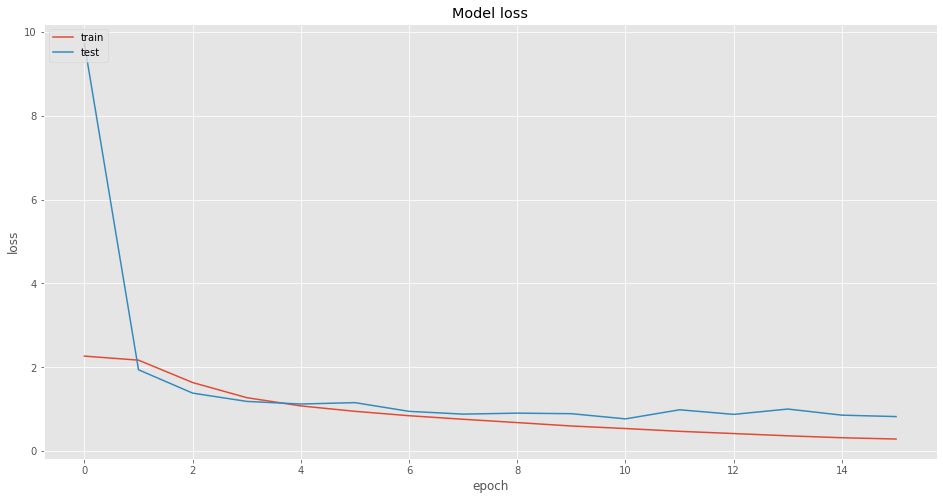

<Figure size 1440x720 with 0 Axes>

In [26]:
plot_training_history(ResNet50_model_history)

In [27]:
best_ResNet50 = tf.keras.models.load_model(checkpoint_ResNet50_name)
ResNet50_validation = best_ResNet50.evaluate(X_test, y_test_cat, batch_size=batch_size)
print(" ResNet50 Validation results ".center(50, "="))
print(f"Test loss: {ResNet50_validation[0]}, Test accuracy: {ResNet50_validation[1]}")

time1 = time.perf_counter()
predictions = best_ResNet50.predict(X_test)
time2 = time.perf_counter()
best_inceptionV3_model_inference_time = ((time2 - time1)/X_test.shape[0]) * 1000

625/625 [==============================] - 8s 12ms/step - loss: 0.7679 - accuracy: 0.7369
========== ResNet50 Validation results ===========
Test loss: 0.7679286003112793, Test accuracy: 0.7368999719619751


---

# Final comparison

In [34]:
# Creating a list with the information of the trainings
battle_info = [
    ["Best of GA",  genetic_validation[1], best_genetic_model_inference_time],
    ["VGG19",       vgg19_validation[1], best_vgg19_model_inference_time],
    ["ResNet50", ResNet50_validation[1], best_inceptionV3_model_inference_time]
]

print(
    tabulate(
        battle_info,
        headers=["Network", "Accuracy", "Inference time (ms)"],
        numalign="center", stralign="center"
    )
)

 Network     Accuracy    Inference time (ms)
----------  ----------  ---------------------
Best of GA    0.8385          0.558647
  VGG19       0.7291          0.351754
 ResNet50     0.7369          0.639222


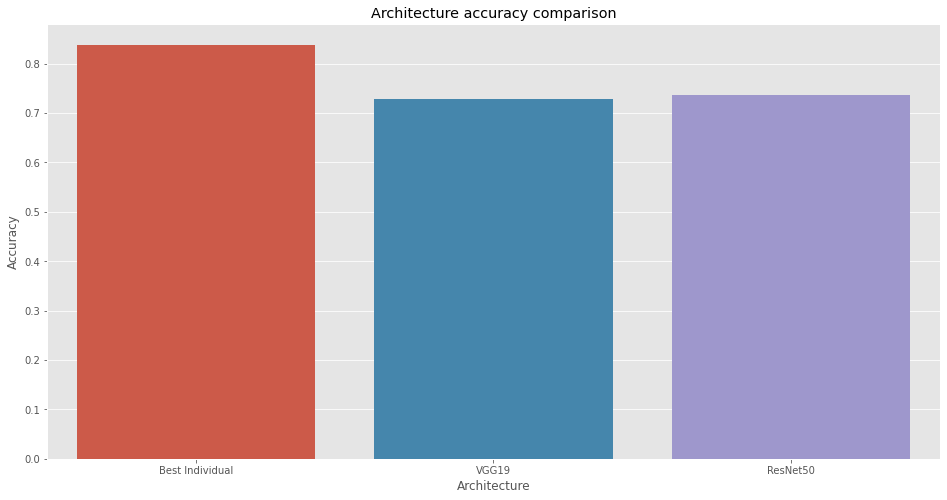

In [35]:
accuracy_list = [genetic_validation[1], vgg19_validation[1], ResNet50_validation[1]]

sns.barplot(x=["Best Individual", "VGG19", "ResNet50"], y=accuracy_list)
plt.title("Architecture accuracy comparison")
plt.xlabel("Architecture")
plt.ylabel("Accuracy")
plt.show()